In [1]:
import pandas as pd
import tensorflow as tf
import custom_metrics as cm
import sklearn as sk
import numpy as np
import math
import data_preprocessing as dp
import expenditure_predictor as ep
import matplotlib.pyplot as plt
import feature_selection as fs
import data_analysis as da
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import svm
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import kstest_normal
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing

# ¿Nuestro dataset sigue una distribución normal?  

Antes de plantearnos qué tipo de escalado usar en los datos, debemos dar respuesta a esta pregunta.  
Para ello recurriremos tanto a un análisis visual como a los tests pertinentes, como en este caso será el test de Kolmogorov-Smirnof

In [2]:
X = dp.load_dataset('./datos/GASTO_TURISTICO_2018_ORIGINAL_2.csv', ';', ',', predictors=None, dummies=False, desglose=False)
X = pd.get_dummies(X)

c:\users\amct2\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\amct2\PycharmProjects\tfg\data_preprocessing.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = x[(y > q1 - IQR)]


In [3]:
y = X.pop('GASTO')
normality_test = kstest_normal(y, dist='norm')

c:\users\amct2\appdata\local\programs\python\python36\lib\site-packages\statsmodels\stats\_lilliefors.py:272: FutureWarning: The default pvalmethod will change from "approx" to "table" after 0.11. The "table" method uses values from a very large simulation and is more accurate.  Explicitly set this parameter to "approx" or "table" to silence this warning
  warnings.warn(msg, FutureWarning)


H0: La muestra sigue una distribución normal  
H1: La muestra NO sigue una distribución normal

0.0 < 0.05 -> Rechazamos la hipótesis nula, la muestra no se distribuye siguiendo una normal

---Test de Kolmogorov-Smirnnof---
{'KS Stat': 0.05886676258187584, 'KS-Test p-value': 0.0}
Fallamos al aceptar la hipótesis nula, ergo la variable no se distribuye según una normal.


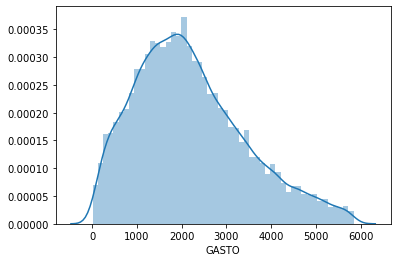

In [4]:
da.normality_test(y)

# Evaluación de la heterocedasticidad del modelo definitivo

In [7]:
literatura_corr1 = ['NOCHES', 'PERSONAS_TOTAL', 'INGRESOS', 'EDAD', 'ACTIV_PISCINA',
                    'ACTIV_PARQUES_OCIO', 'ALOJ_CATEG_HOTEL4', 'ALOJ_CATEG_HOTEL5',
                    'PAQUETE_TURISTICO_ALGUNO_GRATIS', 'ALOJ_CATEG_PROPIA',
                    'PAQUETE_TURISTICO_SI','NACIONALIDAD_ESP724' ]


X = dp.load_dataset('./datos/GASTO_TURISTICO_2018_ORIGINAL_2.csv', ';', ',', predictors=literatura_corr1, dummies=True, desglose=False)

print(X.shape)

for col in X.columns:
        if col.endswith('NO_SABE') or col.endswith('NO_CONTESTA') or col.endswith('-1'):
            X = X.loc[X[col] == 0]
            X.pop(col)
print(X.shape)

y = X.pop('GASTO')


scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
print(X.head)

form ='GASTO~' 
for col in X.columns:
    form +='+'+col
print(form)
X['GASTO'] = y


c:\users\amct2\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(35767, 13)
(35767, 13)
<bound method NDFrame.head of          NOCHES  PERSONAS_TOTAL  INGRESOS      EDAD  ACTIV_PISCINA  \
0      0.200000        0.071429     0.000  0.341772            1.0   
1      0.233333        0.142857     0.392  0.316456            1.0   
2      0.300000        0.071429     0.000  0.683544            0.0   
3      0.100000        0.071429     0.392  0.164557            0.0   
4      0.200000        0.214286     0.792  0.278481            1.0   
...         ...             ...       ...       ...            ...   
37899  0.133333        0.071429     0.792  0.556962            1.0   
37900  0.433333        0.142857     1.000  0.417722            1.0   
37901  0.333333        0.071429     0.392  0.164557            1.0   
37902  0.200000        0.071429     0.392  0.139241            1.0   
37903  0.433333        0.214286     0.392  0.468354            1.0   

       ACTIV_PARQUES_OCIO  ALOJ_CATEG_HOTEL4  ALOJ_CATEG_HOTEL5  \
0                     0.0             

C:\Users\amct2\PycharmProjects\tfg\data_preprocessing.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = x[(y > q1 - IQR)]


In [8]:
expenditure_model = ols(formula=form, data=X).fit()
da.heteroskedasticity_test(X, form)

---Test de White---
{'LM Statistic': 4145.6350160004595, 'LM-Test p-value': 0.0, 'F-Statistic': 59.98436399822094, 'F-Test p-value': 0.0}
---Test de BP---
{'LM Statistic': 3209.8799664602025, 'LM-Test p-value': 0.0, 'F-Statistic': 293.75563164726066, 'F-Test p-value': 0.0}


In [9]:
# Con literatura corr 0,1
expenditure_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GASTO   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     3051.
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:49:55   Log-Likelihood:            -2.9286e+05
No. Observations:               35767   AIC:                         5.857e+05
Df Residuals:                   35754   BIC:                         5.859e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          18.9643     18.216      1.041      0.298     -16.739      54.668
NOCHES                           3054.3607     37.460     81.536      0.000    2980.938    3127.784
PERSONAS_TOTAL                   6466.5808     56.919    113.611      0.000    6355.018    6578.143
INGRESOS                          377.5077     13.828     27.300      0.000     350.404     404.611
EDAD                              430.6135     26.194     16.439      0.000     379.273     481.954
ACTIV_PISCINA                      97.1014      9.971      9.739      0.000      77.558     116.644
ACTIV_PARQUES_OCIO                144.5378     13.215     10.937      0.000     118.635     170.441
ALOJ_CATEG_HOTEL4                 234.0030     10.637     21.998      0.000     213.154     254.852
ALOJ_CATEG_HOTEL5                 749.3462     20.323     36.871      0.000     709.512     789.181
PAQUETE_TURISTICO_ALGUNO_GRATIS  -592.4266     21.831    -27.137      0.000    -635.216    -549.637
ALOJ_CATEG_PROPIA                -142.6173     25.645     -5.561      0.000    -192.883     -92.352
PAQUETE_TURISTICO_SI              505.4982     10.635     47.533      0.000     484.654     526.342
NACIONALIDAD_ESP724              -108.4058     13.155     -8.241      0.000    -134.190     -82.622
==============================================================================
Omnibus:                     1496.471   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2823.286
Skew:                           0.324   Prob(JB):                         0.00
Kurtosis:                       4.214   Cond. No.                         19.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""